<a href="https://colab.research.google.com/github/Vreddy0305/Machine-Learning-ML-/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving merged_clean_dataset (1).csv to merged_clean_dataset (1) (1).csv


In [6]:
import pandas as pd

# Use the uploaded filename
df = pd.read_csv("merged_clean_dataset (1).csv")


In [7]:
# ============================================================
# A2 & A4 - Preprocessing Dataset for Regression
# ============================================================

# Load dataset from uploaded file (already uploaded using files.upload())
import pandas as pd
import numpy as np

df = pd.read_csv("merged_clean_dataset (1).csv")   # ✅ no Windows path

# Convert Date + Time into datetime
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'], format="%d-%m-%Y %H:%M")

# Drop old Date/Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Handle missing precipitation (fill with 0)
df['Precipitation_in'] = df['Precipitation_in'].fillna(0)

# Create synthetic target: Hydropower (P = Q * H)
df['Hydropower'] = df['Stream_Flow_cfs'] * df['Gage_Height_ft']

# Features (X) and Target (y)
X = df[['Precipitation_in', 'Reservoir_Storage_acre_ft', 'Stream_Flow_cfs', 'Gage_Height_ft']]
y = df['Hydropower']

# Check first few rows
df.head()


,Site_ID,Timezone,Gage_Height_ft,Status,Precipitation_in,Reservoir_Storage_acre_ft,Stream_Flow_cfs,Datetime,Hydropower
0,8474107,IST,20.19,P,0.0,33.99,1.24,2025-01-01 11:45:00,25.0356
1,8474107,IST,20.19,P,0.0,33.99,1.24,2025-01-01 12:00:00,25.0356
2,8474107,IST,20.20,P,0.0,34.09,1.32,2025-01-01 12:15:00,26.6640
3,8474107,IST,20.20,P,0.0,34.09,1.32,2025-01-01 12:30:00,26.6640
4,8474107,IST,20.19,P,0.0,33.99,1.24,2025-01-01 12:45:00,25.0356


In [8]:
# ============================================================
# A2 - Train-Test Split + Scaling (for regression models)
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for SVR, MLP, etc.)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training features shape:", X_train_scaled.shape)
print("Testing features shape:", X_test_scaled.shape)


Training features shape: (7237, 4)
Testing features shape: (1810, 4)


In [9]:
# ============================================================
# A4 - Baseline Regression Models
# ============================================================

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "MLP Regressor": MLPRegressor(max_iter=1000, random_state=42)
}

# Dictionary to store results
results = []

# Train & Evaluate each model
for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results.append([name, train_r2, test_r2, test_rmse, test_mae])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Train R2", "Test R2", "Test RMSE", "Test MAE"])
print(results_df)


               Model  Train R2   Test R2   Test RMSE   Test MAE
0  Linear Regression  0.999917  0.999898    1.382183   0.518488
1      Decision Tree  1.000000  0.999811    1.882235   0.211739
2      Random Forest  0.999977  0.999868    1.574723   0.190043
3                SVR  0.246750  0.278756  116.375170  16.693367
4      MLP Regressor  0.999981  0.999974    0.704604   0.194453


In [11]:
# ============================================================
# A2 - Hyperparameter Tuning using RandomizedSearchCV
# ============================================================

from sklearn.model_selection import RandomizedSearchCV

# ---------- Random Forest ----------
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, cv=3,
                               scoring='r2', random_state=42, n_jobs=-1)
rf_search.fit(X_train_scaled, y_train)

print("Best Random Forest Params:", rf_search.best_params_)
print("Best Random Forest Score (CV R2):", rf_search.best_score_)


# ---------- Support Vector Regressor ----------
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly']
}

svr = SVR()
svr_search = RandomizedSearchCV(svr, svr_param_grid, n_iter=10, cv=3,
                                scoring='r2', random_state=42, n_jobs=-1)
svr_search.fit(X_train_scaled, y_train)

print("Best SVR Params:", svr_search.best_params_)
print("Best SVR Score (CV R2):", svr_search.best_score_)


# ---------- MLP Regressor ----------
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01]
}

mlp = MLPRegressor(max_iter=1000, random_state=42)
mlp_search = RandomizedSearchCV(mlp, mlp_param_grid, n_iter=10, cv=3,
                                scoring='r2', random_state=42, n_jobs=-1)
mlp_search.fit(X_train_scaled, y_train)

print("Best MLP Params:", mlp_search.best_params_)
print("Best MLP Score (CV R2):", mlp_search.best_score_)


Best Random Forest Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best Random Forest Score (CV R2): 0.999389630498296
Best SVR Params: {'kernel': 'linear', 'gamma': 'auto', 'C': 10}
Best SVR Score (CV R2): 0.9998846657885977


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 754, in fit
    return sel

Best MLP Params: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'activation': 'relu'}
Best MLP Score (CV R2): 0.9999236687048872


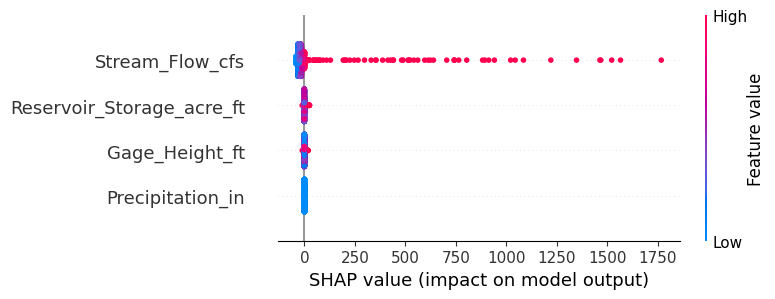

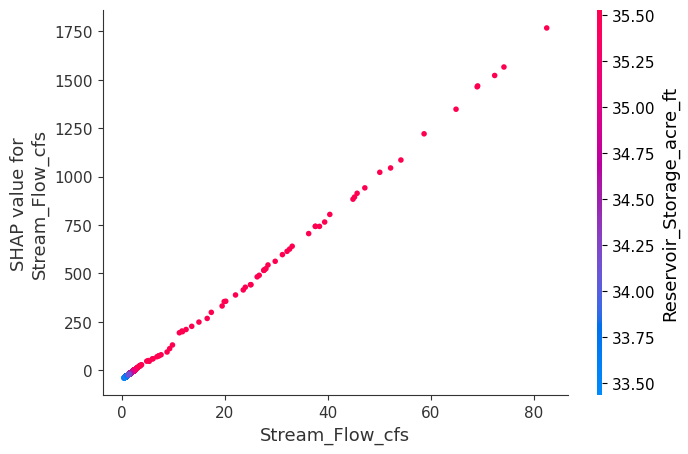

In [12]:
# ============================================================
# O1 - Explainability with SHAP
# ============================================================

import shap

# Use the best Random Forest model from RandomizedSearchCV
best_rf = rf_search.best_estimator_

# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Dependence plot (example: how Stream_Flow_cfs impacts prediction)
shap.dependence_plot("Stream_Flow_cfs", shap_values, X_test, feature_names=X.columns)


In [13]:
# ============================================================
# O2 - Local Interpretability with LIME
# ============================================================

from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data = X_train_scaled,
    training_labels = y_train.values,
    feature_names = X.columns.tolist(),
    mode = "regression"
)

# Pick one test instance (example: first row of X_test)
i = 0
test_instance = X_test_scaled[i].reshape(1, -1)

# Explain prediction for this instance
lime_exp = lime_explainer.explain_instance(
    X_test_scaled[i],
    best_rf.predict,
    num_features=4
)

# Show explanation in notebook
lime_exp.show_in_notebook(show_table=True)

# Or save as HTML
lime_exp.save_to_file("lime_explanation.html")


ModuleNotFoundError: No module named 'lime'